# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

# Non shared resources
filename = 'hoasa-mc-kmeans'
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['ac', 'air_panas', 'bau', 'general', 'kebersihan', 'linen', 'service', 'sunrise_meal', 'tv', 'wifi']
aspect_mapping = {'ac': 0, 'air_panas': 1, 'bau': 2, 'general': 3, 'kebersihan': 4, 'linen': 5, 'service': 6, 'sunrise_meal': 7, 'tv': 8, 'wifi': 9}
label_mapping = {"neg": 0, "neut": 1, 'neg_pos': 1, 'pos': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/hoasa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/hoasa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/hoasa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,review,ac,air_panas,bau,general,kebersihan,linen,service,sunrise_meal,tv,wifi
0,kebersihan kurang...,neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
1,"sangat mengecewakan... hotel bad image, kebers...",neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
2,Tempat nyaman bersih tapi tv terlalu tinggi ti...,neut,neut,neut,neut,pos,neut,neut,neut,neg,neut
3,"semuanya bagus sesuai profile,dan harga promo ...",neut,neg,neut,pos,neut,neut,neut,neut,neut,neut
4,"Tempat tidur sangat keras, bantal besar dan ke...",neg,neg,neut,neut,neut,neg,neut,neut,neut,neut


In [7]:
data.head()

,review,ac,air_panas,bau,general,kebersihan,linen,service,sunrise_meal,tv,wifi
0,kebersihan kurang...,neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
1,"sangat mengecewakan... hotel bad image, kebers...",neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
2,Tempat nyaman bersih tapi tv terlalu tinggi ti...,neut,neut,neut,neut,pos,neut,neut,neut,neg,neut
3,"semuanya bagus sesuai profile,dan harga promo ...",neut,neg,neut,pos,neut,neut,neut,neut,neut,neut
4,"Tempat tidur sangat keras, bantal besar dan ke...",neg,neg,neut,neut,neut,neg,neut,neut,neut,neut


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [9]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['review'].values
y_train = train_data[train_labels].values
X_val = val_data['review'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2283,) (2283, 10)
(571,) (571, 10)


# BUILD DATASET & DATALOADERS

In [10]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=sequence_length, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

In [11]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [12]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [13]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [14]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# TRAIN THE MODEL

In [15]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 50

In [16]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [17]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }

In [18]:
def train_model(current_train_size, train_indices, aspect_metrics, sentiment_metrics, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    aspect_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    # Freeze the first few layers of the encoder
    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define optimizer and loss function
    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(current_X_train, current_y_train, X_val, y_val, sequence_length)

    # Prepare everything with Accelerator
    aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader
    )

    nearest_cp = current_train_size
    if nearest_cp not in checkpoints:
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    percentage = math.ceil(nearest_cp / total_data * 100)

    aspect_result = None
    start_time = time.time()

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(epochs):
        aspect_model.train()
        epoch_loss = 0

        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            None,
            aspect_list,
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'{filename}-aspect-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            aspect_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nAspect detection accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    accelerator.wait_for_everyone()
    best_aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-model-{percentage}')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("--------------------------------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    sentiment_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=2e-5, weight_decay=0.01)

    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(epochs):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            [0, 1],
            ['negative', 'positive']
        )

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                 f'{filename}-sentiment-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    
    end_time = time.time()
    duration = end_time - start_time

    accelerator.print(f"\nSentiment analysis accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained( f'{filename}-sentiment-model-{percentage}')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    with torch.no_grad():
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
       
        
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])
        
    accelerator.print(f"Total train time: {duration} s")
    accelerator.end_training()
    return

# PLOT THE RESULTS

In [19]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [20]:
def combined_sampling(aspect_model, sentiment_model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    aspect_model.to(device)
    aspect_model.eval()
    sentiment_model.to(device)
    sentiment_model.eval()

    current_train_size = len(train_indices)
    
    # Check nearest checkpoint
    nearest_cp = 0
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    target_samples = math.ceil(0.1*len(remaining_indices))
    if target_samples <= min_increment and min_increment < nearest_cp - current_train_size:
        target_samples = min_increment
    elif target_samples > min_increment and target_samples < nearest_cp - current_train_size:
        target_samples = target_samples
    else:
        target_samples = nearest_cp - current_train_size

    final_cp = False
    if current_train_size >= checkpoints[-1] - target_samples:
        final_cp = True

        if accelerator.is_main_process:
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'ac': [y_train[i][0] for i in temp],
                'air_panas': [y_train[i][1] for i in temp],
                'bau': [y_train[i][2] for i in temp],
                'general': [y_train[i][3] for i in temp],
                'kebersihan': [y_train[i][4] for i in temp],
                'linen': [y_train[i][5] for i in temp],
                'service': [y_train[i][6] for i in temp],
                'sunrise_meal': [y_train[i][7] for i in temp],
                'tv': [y_train[i][8] for i in temp],
                'wifi': [y_train[i][9] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            
            sampling_dur.append(0)
            for i in remaining_indices:
                new_samples.append(i)
                
    accelerator.wait_for_everyone()
    if not final_cp:
        aspect_dataset = AspectDetectionDataset(
            X_pool, 
            [['neut' for i in range(len(train_labels))] for x in range(len(X_pool))], 
            label_mapping, 
            tokenizer, 
            max_length=sequence_length
        )
        aspect_loader = DataLoader(
            aspect_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True,
        )

        start_time = time.time()

        mc_indices = monte_carlo_dropout_sampling(aspect_model, sentiment_model, aspect_loader, device, target_samples)
        mc_indices = [remaining_indices[i] for i in mc_indices]
        accelerator.print(f"Got {len(mc_indices)} samples from mc")

        kmeans_indices = kmeans_clustering_sampling(aspect_model, sentiment_model, aspect_loader, device, target_samples)
        kmeans_indices = [remaining_indices[i] for i in kmeans_indices]
        accelerator.print(f"Got {len(kmeans_indices)} samples from kmeans")

        if accelerator.is_main_process:
            # Combine both methods' results
            combined_indices = list(set(mc_indices).union(set(kmeans_indices)))
            
            # If we got more than we need, take only what we need
            if len(combined_indices) > target_samples:
                np.random.shuffle(combined_indices)
                combined_indices = combined_indices[:target_samples]
            
            # Calculate duration
            end_time = time.time()
            duration = end_time - start_time
            
            # Check if we've reached a checkpoint
            if current_train_size + len(combined_indices) >= nearest_cp:
                temp = train_indices.copy()
                temp.extend(combined_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'ac': [y_train[i][0] for i in temp],
                    'air_panas': [y_train[i][1] for i in temp],
                    'bau': [y_train[i][2] for i in temp],
                    'general': [y_train[i][3] for i in temp],
                    'kebersihan': [y_train[i][4] for i in temp],
                    'linen': [y_train[i][5] for i in temp],
                    'service': [y_train[i][6] for i in temp],
                    'sunrise_meal': [y_train[i][7] for i in temp],
                    'tv': [y_train[i][8] for i in temp],
                    'wifi': [y_train[i][9] for i in temp],
                })
                acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
            
            # Log results
            print("Nearest checkpoint:", nearest_cp)
            print(f"Acquired samples: {len(combined_indices)}")
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in combined_indices:
                new_samples.append(i)

In [21]:
def monte_carlo_dropout_sampling(aspect_model, sentiment_model, aspect_loader, device, target_samples, mc_passes=3):
    aspect_outputs = {}
    sentiment_outputs = {}

    aspects = []
    data = []
    labels = []
    indices = []

    aspect_uncertainties = []

    # Pass through aspect detction model
    for batch in aspect_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)

        batch_probs = []
        
        for i in range(mc_passes):
            with torch.no_grad():
                outputs = aspect_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids).logits
                probs = torch.sigmoid(outputs).cpu().numpy()  # Shape: (batch_size, num_classes)
                batch_probs.append(probs)
                
        # Stack the probabilities from multiple MC passes
        batch_probs = np.stack(batch_probs, axis=0)  # Shape: (mc_passes, batch_size, num_classes)

        # Calculate mean probability and uncertainty for each sample in the batch
        mean_probs = np.mean(batch_probs, axis=0)  # Shape: (batch_size, num_classes)
        uncertainties = np.mean(np.var(batch_probs, axis=0), axis=1)  # Shape: (batch_size,)
        aspect_uncertainties.extend(uncertainties)

        for i in range(len(mean_probs)):
            aspect_outputs[batch['ori_indices'][i].item()] = [np.max(torch.sigmoid(outputs[i]).cpu().numpy())]
            
            for j in range(len(mean_probs[i])):
                if int(mean_probs[i][j].round()) != 1:
                    aspects.append(aspect_list[j])
                    data.append(batch['ori_text'][i])
                    labels.append(batch['ori_label'][i][j])
                    indices.append(batch['ori_indices'][i])

    aspect_outputs = {i: aspect_uncertainties[i] for i in range(len(aspect_uncertainties))}
    sentiment_dataset = SentimentAnalysisDataset(data, labels, aspects, indices, label_mapping, tokenizer, max_length=sequence_length)
    sentiment_loader = torch.utils.data.DataLoader(
        sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
    )

    # Pass through sentiment analysis model
    for batch in sentiment_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)

        batch_probs = []
        for i in range(mc_passes):
            with torch.no_grad():
                outputs = sentiment_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
                preds = torch.sigmoid(outputs.logits)

                for j in range(len(preds)):
                    ori_index = batch['ori_indices'][j].item()
                    if ori_index in sentiment_outputs.keys():
                        sentiment_outputs[ori_index].append(preds[j].cpu().numpy())
                    else:
                        sentiment_outputs[ori_index] = [preds[j].cpu().numpy()]

    for indices, probs in sentiment_outputs.items():
        sentiment_outputs[indices] = [[probs[i], probs[i+1], probs[i+2]] for i in range(int(len(probs) / 3))]
        
        variance = np.var(sentiment_outputs[indices], axis=1)
        mean_aspect_variance = np.mean(variance, axis=1)
        mean_data_variance = np.mean(mean_aspect_variance)
        
        sentiment_outputs[indices] = np.mean(np.mean(np.var(sentiment_outputs[indices], axis=0), axis=0), axis=0)

    aspect_outputs = dict(sorted(aspect_outputs.items()))
    if len(data) > 0:
        for key, val in sentiment_outputs.items():
            aspect_outputs[key] = (val + aspect_outputs[key]) / 2

    uncertainties = np.array(list(aspect_outputs.values()))
    sorted_unc = np.argsort(uncertainties)
    sorted_unc = sorted_unc[::-1]

    threshold = np.percentile(uncertainties, 90)
    least_confident_indices = sorted_unc[:target_samples]

    return least_confident_indices

In [22]:
def kmeans_clustering_sampling(aspect_model, sentiment_model, aspect_loader, device, target_samples, n_clusters=min_increment):
    aspect_outputs = {}
    sentiment_outputs = {}

    aspects = []
    data = []
    labels = []
    indices = []

    # Pass through aspect detction model
    for batch in aspect_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        
        with torch.no_grad():
            outputs = aspect_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids).logits
            embeddings = aspect_model.base_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        for i in range(len(outputs)):
            aspect_outputs[batch['ori_indices'][i].item()] = embeddings.last_hidden_state[i].mean(dim=1).cpu().numpy()
            
            for j in range(len(outputs[i])):
                if int(outputs[i][j].round()) != 1:
                    aspects.append(aspect_list[j])
                    data.append(batch['ori_text'][i])
                    labels.append(batch['ori_label'][i][j])
                    indices.append(batch['ori_indices'][i])

    if len(data) > 0:
        sentiment_dataset = SentimentAnalysisDataset(data, labels, aspects, indices, label_mapping, tokenizer, max_length=sequence_length)
        sentiment_loader = torch.utils.data.DataLoader(
            sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
        )
    
        # Pass through sentiment analysis model
        for batch in sentiment_loader:
            token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
    
            with torch.no_grad():
                outputs = sentiment_model.base_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    
            for i in range(len(outputs.last_hidden_state)):
                ori_index = batch['ori_indices'][i].item()
                if ori_index in sentiment_outputs.keys():
                    sentiment_outputs[ori_index].append(outputs.last_hidden_state[i].mean(dim=1).cpu().numpy())
                else:
                    sentiment_outputs[ori_index] = [outputs.last_hidden_state[i].mean(dim=1).cpu().numpy()]

    for key, val in sentiment_outputs.items():
        sentiment_outputs[key] = np.mean(val, axis=0)

    collected_indices = set()  # Initialize set to store selected indices
    thresholds = []

    aspect_outputs = dict(sorted(aspect_outputs.items()))

    if len(data) > 0:
        for key, val in sentiment_outputs.items():
            aspect_outputs[key] = np.mean([val, aspect_outputs[key]], axis=0)

    embeddings = np.array(list(aspect_outputs.values()))

    # Cluster the data based on its embeddings
    kmeans=KMeans(n_clusters=n_clusters, n_init=1)
    kmeans.fit(embeddings)
    
    for cluster_id in range(n_clusters):
        # Cluster center and indices of samples in the current cluster
        cluster_center = kmeans.cluster_centers_[cluster_id]
        cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
    
        if cluster_indices.size == 0:
            # Skip clusters with no members
            print(f"Cluster {cluster_id} has no members, skipping.")
            continue
    
        # Calculate distances of each point in the cluster from the cluster center
        cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
    
        # Determine the local threshold (10th percentile of closest distances to cluster center)
        local_threshold = np.percentile(cluster_distances, 90)
        thresholds.append(local_threshold)
    
        below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
        collected_indices.update(below_threshold_indices)

    # To handle multiple points with same distance
    if len(collected_indices) > target_samples:
        collected_indices = np.array(list(collected_indices))
        np.random.shuffle(collected_indices)
        collected_indices = collected_indices[:target_samples]

    return collected_indices[:target_samples]

# MAIN LOOP

In [23]:
def active_learning(seed, i):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size

    aspect_model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1')
    sentiment_model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1')
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (
            current_train_size, 
            train_indices, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            i,
            seed
        )
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)

        aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-model-{percentage}')
        sentiment_model = BertForSequenceClassification.from_pretrained(f'{filename}-sentiment-model-{percentage}')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (
            aspect_model, 
            sentiment_model, 
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            sampling_dur, 
            new_samples, 
            i
        )
        notebook_launcher(combined_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (
        current_train_size, 
        train_indices, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        i,
        seed
    )
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    aspect_accuracies, aspect_f1_micros, aspect_f1_macros = list(aspect_accuracies), list(aspect_f1_micros), list(aspect_f1_macros)
    sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros = list(sentiment_accuracies), list(sentiment_f1_micros), list(sentiment_f1_macros)
    
    end_time = time.time()
    duration = end_time - start_time
    
    # print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [24]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6307, Accuracy: 0.7977, F1 Micro: 0.8873, F1 Macro: 0.8829
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4656, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4304, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4322, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4202, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4242, Accuracy: 0.803, F1 Micro: 0.8902, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3975, Accuracy: 0.8101, F1 Micro: 0.893, F1 Macro: 0.8864
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3872, Accuracy: 0.8142, F1 Micro: 0.8957, F1 Macro: 0.8903
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6011, Accuracy: 0.6228, F1 Micro: 0.6228, F1 Macro: 0.3838
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.566, Accuracy: 0.6228, F1 Micro: 0.6228, F1 Macro: 0.3838
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5116, Accuracy: 0.6228, F1 Micro: 0.6228, F1 Macro: 0.3838
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.525, Accuracy: 0.6228, F1 Micro: 0.6228, F1 Macro: 0.3838
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4475, Accuracy: 0.7241, F1 Micro: 0.7241, F1 Macro: 0.641
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.33, Accuracy: 0.7494, F1 Micro: 0.7494, F1 Macro: 0.694
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2937, Accuracy: 0.7797, F1 Micro: 0.7797, F1 Macro: 0.753
Epoch 8/10, Train Loss: 0.2774, Accuracy: 0.7544, F1 Micro: 0.7544, F1 Macro: 0.7104
Epoch 9/10, Train Loss: 0.1782, Accuracy: 0.7696, F1 Micro: 0.7696, F1 Macro: 0.747
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5499, Accuracy: 0.801, F1 Micro: 0.8894, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4743, Accuracy: 0.8059, F1 Micro: 0.8917, F1 Macro: 0.8873
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4454, Accuracy: 0.8142, F1 Micro: 0.8941, F1 Macro: 0.8874
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4112, Accuracy: 0.8236, F1 Micro: 0.8995, F1 Macro: 0.8935
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3815, Accuracy: 0.8458, F1 Micro: 0.911, F1 Macro: 0.905
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3355, Accuracy: 0.8762, F1 Micro: 0.9267, F1 Macro: 0.9204
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2928, Accuracy: 0.8813, F1 Micro: 0.9298, F1 Macro: 0.9255
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2669, Accuracy: 0.9061, F1 Micro: 0.943, F1 Macro: 0.9376
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5472, Accuracy: 0.7545, F1 Micro: 0.7545, F1 Macro: 0.43
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3957, Accuracy: 0.8248, F1 Micro: 0.8248, F1 Macro: 0.7613
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3642, Accuracy: 0.8483, F1 Micro: 0.8483, F1 Macro: 0.77
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3207, Accuracy: 0.8538, F1 Micro: 0.8538, F1 Macro: 0.7628
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2528, Accuracy: 0.8579, F1 Micro: 0.8579, F1 Macro: 0.7819
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2094, Accuracy: 0.8703, F1 Micro: 0.8703, F1 Macro: 0.814
Epoch 7/10, Train Loss: 0.1936, Accuracy: 0.869, F1 Micro: 0.869, F1 Macro: 0.8018
Epoch 8/10, Train Loss: 0.1314, Accuracy: 0.8648, F1 Micro: 0.8648, F1 Macro: 0.7866
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1212, Accuracy: 0.8828, F1 Micro: 0.8828, F1 Macro: 0.8336
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5446, Accuracy: 0.8014, F1 Micro: 0.8896, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4787, Accuracy: 0.8165, F1 Micro: 0.8956, F1 Macro: 0.8894
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4525, Accuracy: 0.8297, F1 Micro: 0.9031, F1 Macro: 0.8975
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3905, Accuracy: 0.8694, F1 Micro: 0.9235, F1 Macro: 0.9179
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3386, Accuracy: 0.8906, F1 Micro: 0.9351, F1 Macro: 0.9308
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.281, Accuracy: 0.9172, F1 Micro: 0.95, F1 Macro: 0.946
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2451, Accuracy: 0.9295, F1 Micro: 0.957, F1 Macro: 0.9541
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2079, Accuracy: 0.9321, F1 Micro: 0.9587, F1 Macro: 0.9557
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5444, Accuracy: 0.8081, F1 Micro: 0.8081, F1 Macro: 0.7505
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4462, Accuracy: 0.8278, F1 Micro: 0.8278, F1 Macro: 0.7311
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3163, Accuracy: 0.8641, F1 Micro: 0.8641, F1 Macro: 0.8098
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2824, Accuracy: 0.8683, F1 Micro: 0.8683, F1 Macro: 0.8206
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2247, Accuracy: 0.8745, F1 Micro: 0.8745, F1 Macro: 0.8232
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1407, Accuracy: 0.8828, F1 Micro: 0.8828, F1 Macro: 0.8389
Epoch 7/10, Train Loss: 0.1089, Accuracy: 0.8786, F1 Micro: 0.8786, F1 Macro: 0.8337
Epoch 8/10, Train Loss: 0.0921, Accuracy: 0.8745, F1 Micro: 0.8745, F1 Macro: 0.8198
Epoch 9/10, Train Loss: 0.0815, Accuracy: 0.8817, F1 Micro: 0.8817, F1 Macro: 0.8337
Higher F1 achieved, saving model
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5285, Accuracy: 0.8019, F1 Micro: 0.8899, F1 Macro: 0.8855
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.47, Accuracy: 0.821, F1 Micro: 0.8972, F1 Macro: 0.8903
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4096, Accuracy: 0.8767, F1 Micro: 0.9266, F1 Macro: 0.9187
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3361, Accuracy: 0.9005, F1 Micro: 0.9406, F1 Macro: 0.9363
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2735, Accuracy: 0.9203, F1 Micro: 0.9517, F1 Macro: 0.9473
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2314, Accuracy: 0.9335, F1 Micro: 0.9597, F1 Macro: 0.9567
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2019, Accuracy: 0.9391, F1 Micro: 0.9627, F1 Macro: 0.9595
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.181, Accuracy: 0.9444, F1 Micro: 0.966, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5526, Accuracy: 0.8316, F1 Micro: 0.8316, F1 Macro: 0.75
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3643, Accuracy: 0.8626, F1 Micro: 0.8626, F1 Macro: 0.8047
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2619, Accuracy: 0.8802, F1 Micro: 0.8802, F1 Macro: 0.8356
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1977, Accuracy: 0.8895, F1 Micro: 0.8895, F1 Macro: 0.8393
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1331, Accuracy: 0.8946, F1 Micro: 0.8946, F1 Macro: 0.855
Epoch 6/10, Train Loss: 0.1131, Accuracy: 0.8926, F1 Micro: 0.8926, F1 Macro: 0.8451
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0896, Accuracy: 0.8998, F1 Micro: 0.8998, F1 Macro: 0.8611
Epoch 8/10, Train Loss: 0.0577, Accuracy: 0.8957, F1 Micro: 0.8957, F1 Macro: 0.8493
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0566, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8681
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.527, Accuracy: 0.8023, F1 Micro: 0.8901, F1 Macro: 0.8856
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4592, Accuracy: 0.8429, F1 Micro: 0.909, F1 Macro: 0.9025
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3632, Accuracy: 0.8951, F1 Micro: 0.9374, F1 Macro: 0.9331
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3068, Accuracy: 0.9234, F1 Micro: 0.9534, F1 Macro: 0.9491
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2514, Accuracy: 0.9356, F1 Micro: 0.9609, F1 Macro: 0.9583
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2056, Accuracy: 0.9425, F1 Micro: 0.9649, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1791, Accuracy: 0.9465, F1 Micro: 0.9671, F1 Macro: 0.9645
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1517, Accuracy: 0.9465, F1 Micro: 0.9672, F1 Macro: 0.9647
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5424, Accuracy: 0.8635, F1 Micro: 0.8635, F1 Macro: 0.8128
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3471, Accuracy: 0.8765, F1 Micro: 0.8765, F1 Macro: 0.8275
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2741, Accuracy: 0.9026, F1 Micro: 0.9026, F1 Macro: 0.8723
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2065, Accuracy: 0.9106, F1 Micro: 0.9106, F1 Macro: 0.8835
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.162, Accuracy: 0.9106, F1 Micro: 0.9106, F1 Macro: 0.882
Epoch 6/10, Train Loss: 0.1166, Accuracy: 0.9086, F1 Micro: 0.9086, F1 Macro: 0.8799
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0851, Accuracy: 0.9127, F1 Micro: 0.9127, F1 Macro: 0.8855
Epoch 8/10, Train Loss: 0.0763, Accuracy: 0.9026, F1 Micro: 0.9026, F1 Macro: 0.8736
Epoch 9/10, Train Loss: 0.0724, Accuracy: 0.9096, F1 Micro: 0.9096, F1 Macro: 0.8798
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5202, Accuracy: 0.8033, F1 Micro: 0.8905, F1 Macro: 0.8856
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.448, Accuracy: 0.8628, F1 Micro: 0.9197, F1 Macro: 0.9136
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3557, Accuracy: 0.9033, F1 Micro: 0.9422, F1 Macro: 0.938
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.282, Accuracy: 0.9319, F1 Micro: 0.9586, F1 Macro: 0.9557
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2322, Accuracy: 0.9401, F1 Micro: 0.9635, F1 Macro: 0.9606
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.192, Accuracy: 0.9483, F1 Micro: 0.9683, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1627, Accuracy: 0.9491, F1 Micro: 0.9687, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1444, Accuracy: 0.9503, F1 Micro: 0.9695, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5084, Accuracy: 0.8304, F1 Micro: 0.8304, F1 Macro: 0.7621
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3427, Accuracy: 0.8656, F1 Micro: 0.8656, F1 Macro: 0.837
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2299, Accuracy: 0.8851, F1 Micro: 0.8851, F1 Macro: 0.8501
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1992, Accuracy: 0.8934, F1 Micro: 0.8934, F1 Macro: 0.8631
Epoch 5/10, Train Loss: 0.1324, Accuracy: 0.8897, F1 Micro: 0.8897, F1 Macro: 0.8567
Epoch 6/10, Train Loss: 0.1141, Accuracy: 0.8916, F1 Micro: 0.8916, F1 Macro: 0.861
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0804, Accuracy: 0.8999, F1 Micro: 0.8999, F1 Macro: 0.873
Epoch 8/10, Train Loss: 0.0855, Accuracy: 0.8925, F1 Micro: 0.8925, F1 Macro: 0.8632
Epoch 9/10, Train Loss: 0.058, Accuracy: 0.8981, F1 Micro: 0.8981, F1 Macro: 0.8709
Epoch 10/10, Train Loss: 0.0361, Accuracy: 0.8934, F1 Micro: 0.8934, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5151, Accuracy: 0.8082, F1 Micro: 0.8922, F1 Macro: 0.8858
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.428, Accuracy: 0.8814, F1 Micro: 0.9296, F1 Macro: 0.9233
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3223, Accuracy: 0.9231, F1 Micro: 0.9535, F1 Macro: 0.9502
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2557, Accuracy: 0.9363, F1 Micro: 0.9611, F1 Macro: 0.9583
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2134, Accuracy: 0.9453, F1 Micro: 0.9665, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1773, Accuracy: 0.9503, F1 Micro: 0.9694, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1456, Accuracy: 0.9521, F1 Micro: 0.9704, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1326, Accuracy: 0.9528, F1 Micro: 0.971, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4808, Accuracy: 0.8385, F1 Micro: 0.8385, F1 Macro: 0.8084
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3188, Accuracy: 0.888, F1 Micro: 0.888, F1 Macro: 0.8569
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2116, Accuracy: 0.9001, F1 Micro: 0.9001, F1 Macro: 0.8731
Epoch 4/10, Train Loss: 0.1626, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.8726
Epoch 5/10, Train Loss: 0.1088, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.8706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0947, Accuracy: 0.9029, F1 Micro: 0.9029, F1 Macro: 0.8765
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.9029, F1 Micro: 0.9029, F1 Macro: 0.8784
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0679, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8768
Epoch 9/10, Train Loss: 0.039, Accuracy: 0.8898, F1 Micro: 0.8898, F1 Macro: 0.8567
Epoch 10/10, Train Loss: 0.0406, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5166, Accuracy: 0.8146, F1 Micro: 0.8961, F1 Macro: 0.8917
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4161, Accuracy: 0.8941, F1 Micro: 0.9368, F1 Macro: 0.9311
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3114, Accuracy: 0.9332, F1 Micro: 0.9592, F1 Macro: 0.9559
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2459, Accuracy: 0.9425, F1 Micro: 0.9648, F1 Macro: 0.9623
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.193, Accuracy: 0.9488, F1 Micro: 0.9685, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.165, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9696
Epoch 7/10, Train Loss: 0.1413, Accuracy: 0.9556, F1 Micro: 0.9725, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1212, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1075, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4808, Accuracy: 0.8562, F1 Micro: 0.8562, F1 Macro: 0.803
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.304, Accuracy: 0.89, F1 Micro: 0.89, F1 Macro: 0.8577
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1954, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8736
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1547, Accuracy: 0.9032, F1 Micro: 0.9032, F1 Macro: 0.8733
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1043, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0923, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.8856
Epoch 7/10, Train Loss: 0.0604, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8809
Epoch 8/10, Train Loss: 0.0516, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8837
Epoch 9/10, Train Loss: 0.0429, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8839
Epoch 10/10, Train Loss: 0.0275, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5142, Accuracy: 0.8168, F1 Micro: 0.8973, F1 Macro: 0.8931
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3985, Accuracy: 0.8979, F1 Micro: 0.9389, F1 Macro: 0.9329
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2863, Accuracy: 0.9319, F1 Micro: 0.9585, F1 Macro: 0.9556
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2248, Accuracy: 0.9469, F1 Micro: 0.9675, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1924, Accuracy: 0.9517, F1 Micro: 0.9703, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1593, Accuracy: 0.9533, F1 Micro: 0.9713, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1354, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1187, Accuracy: 0.9589, F1 Micro: 0.9746, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4618, Accuracy: 0.8623, F1 Micro: 0.8623, F1 Macro: 0.819
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2855, Accuracy: 0.9025, F1 Micro: 0.9025, F1 Macro: 0.8733
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1758, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8785
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1423, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.8879
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1081, Accuracy: 0.9159, F1 Micro: 0.9159, F1 Macro: 0.8915
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0674, Accuracy: 0.9187, F1 Micro: 0.9187, F1 Macro: 0.895
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0659, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.8984
Epoch 8/10, Train Loss: 0.0416, Accuracy: 0.9149, F1 Micro: 0.9149, F1 Macro: 0.8919
Epoch 9/10, Train Loss: 0.0389, Accuracy: 0.914, F1 Micro: 0.914, F1 Macro: 0.8898
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5081, Accuracy: 0.8148, F1 Micro: 0.8958, F1 Macro: 0.8901
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3874, Accuracy: 0.9023, F1 Micro: 0.9418, F1 Macro: 0.9378
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2709, Accuracy: 0.9387, F1 Micro: 0.9626, F1 Macro: 0.9599
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2141, Accuracy: 0.9469, F1 Micro: 0.9675, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1745, Accuracy: 0.9474, F1 Micro: 0.9678, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1516, Accuracy: 0.9533, F1 Micro: 0.9712, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1307, Accuracy: 0.9594, F1 Micro: 0.9748, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.111, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9727
Epoch 9/10, Train Loss: 0.0936, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.448, Accuracy: 0.864, F1 Micro: 0.864, F1 Macro: 0.82
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.263, Accuracy: 0.8884, F1 Micro: 0.8884, F1 Macro: 0.8561
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1742, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.8791
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1263, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.88
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1095, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.8835
Epoch 6/10, Train Loss: 0.0802, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8755
Epoch 7/10, Train Loss: 0.0616, Accuracy: 0.9053, F1 Micro: 0.9053, F1 Macro: 0.8752
Epoch 8/10, Train Loss: 0.0503, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8779
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5027, Accuracy: 0.8175, F1 Micro: 0.8968, F1 Macro: 0.8902
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3754, Accuracy: 0.9094, F1 Micro: 0.9457, F1 Macro: 0.9419
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2679, Accuracy: 0.9349, F1 Micro: 0.9604, F1 Macro: 0.9573
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2099, Accuracy: 0.9431, F1 Micro: 0.9653, F1 Macro: 0.9625
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1745, Accuracy: 0.9516, F1 Micro: 0.9702, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1498, Accuracy: 0.9557, F1 Micro: 0.9726, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1292, Accuracy: 0.9616, F1 Micro: 0.9761, F1 Macro: 0.9736
Epoch 8/10, Train Loss: 0.1076, Accuracy: 0.9606, F1 Micro: 0.9755, F1 Macro: 0.9726
Epoch 9/10, Train Loss: 0.092, Accuracy: 0.9613, F1 Micro: 0.976, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4379, Accuracy: 0.8469, F1 Micro: 0.8469, F1 Macro: 0.7956
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2834, Accuracy: 0.8886, F1 Micro: 0.8886, F1 Macro: 0.8585
Epoch 3/10, Train Loss: 0.1922, Accuracy: 0.8777, F1 Micro: 0.8777, F1 Macro: 0.8511
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1361, Accuracy: 0.8958, F1 Micro: 0.8958, F1 Macro: 0.8663
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1229, Accuracy: 0.8995, F1 Micro: 0.8995, F1 Macro: 0.8723
Epoch 6/10, Train Loss: 0.0734, Accuracy: 0.894, F1 Micro: 0.894, F1 Macro: 0.8615
Epoch 7/10, Train Loss: 0.074, Accuracy: 0.8967, F1 Micro: 0.8967, F1 Macro: 0.8658
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0432, Accuracy: 0.9022, F1 Micro: 0.9022, F1 Macro: 0.8748
Epoch 9/10, Train Loss: 0.0308, Accuracy: 0.894, F1 Micro: 0.894, F1 Macro: 0.8609
Epoch 10/10, Train Loss: 0.0329, Accuracy: 0.8995, F1 Micro: 0.8995, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4996, Accuracy: 0.8335, F1 Micro: 0.9049, F1 Macro: 0.8997
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3563, Accuracy: 0.908, F1 Micro: 0.9451, F1 Macro: 0.942
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2577, Accuracy: 0.9398, F1 Micro: 0.9633, F1 Macro: 0.9608
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.204, Accuracy: 0.9486, F1 Micro: 0.9685, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1688, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.144, Accuracy: 0.9576, F1 Micro: 0.9739, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1177, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1031, Accuracy: 0.9609, F1 Micro: 0.9759, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3981, Accuracy: 0.8687, F1 Micro: 0.8687, F1 Macro: 0.8139
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2238, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1679, Accuracy: 0.9162, F1 Micro: 0.9162, F1 Macro: 0.8895
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1151, Accuracy: 0.9218, F1 Micro: 0.9218, F1 Macro: 0.8983
Epoch 5/10, Train Loss: 0.0994, Accuracy: 0.9162, F1 Micro: 0.9162, F1 Macro: 0.8884
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0622, Accuracy: 0.9236, F1 Micro: 0.9236, F1 Macro: 0.9016
Epoch 7/10, Train Loss: 0.0553, Accuracy: 0.9209, F1 Micro: 0.9209, F1 Macro: 0.8965
Epoch 8/10, Train Loss: 0.0423, Accuracy: 0.9209, F1 Micro: 0.9209, F1 Macro: 0.8975
Epoch 9/10, Train Loss: 0.0334, Accuracy: 0.9171, F1 Micro: 0.9171, F1 Macro: 0.8906
Epoch 10/10, Train Loss: 0.0153, Accuracy: 0.919, F1 Micro: 0.919, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4952, Accuracy: 0.8262, F1 Micro: 0.9017, F1 Macro: 0.897
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3532, Accuracy: 0.9181, F1 Micro: 0.9507, F1 Macro: 0.9472
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2534, Accuracy: 0.9427, F1 Micro: 0.965, F1 Macro: 0.9626
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2029, Accuracy: 0.951, F1 Micro: 0.9699, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1637, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1384, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9732
Epoch 7/10, Train Loss: 0.1149, Accuracy: 0.9582, F1 Micro: 0.9742, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0998, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0841, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4019, Accuracy: 0.8639, F1 Micro: 0.8639, F1 Macro: 0.8162
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2422, Accuracy: 0.9012, F1 Micro: 0.9012, F1 Macro: 0.8685
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1705, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.876
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1135, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.8979
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.078, Accuracy: 0.9217, F1 Micro: 0.9217, F1 Macro: 0.8988
Epoch 6/10, Train Loss: 0.0827, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Macro: 0.8925
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0558, Accuracy: 0.9226, F1 Micro: 0.9226, F1 Macro: 0.9007
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0396, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9042
Epoch 9/10, Train Loss: 0.0389, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.8922
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4852, Accuracy: 0.8382, F1 Micro: 0.9074, F1 Macro: 0.902
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3452, Accuracy: 0.9224, F1 Micro: 0.9531, F1 Macro: 0.9496
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2449, Accuracy: 0.9432, F1 Micro: 0.9653, F1 Macro: 0.963
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1914, Accuracy: 0.9521, F1 Micro: 0.9705, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1595, Accuracy: 0.9566, F1 Micro: 0.9732, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1365, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1187, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0974, Accuracy: 0.9634, F1 Micro: 0.9772, F1 Macro: 0.9748
Epoch 9/10, Train Loss: 0.0839, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4273, Accuracy: 0.8578, F1 Micro: 0.8578, F1 Macro: 0.8092
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2612, Accuracy: 0.8922, F1 Micro: 0.8922, F1 Macro: 0.8613
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1661, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8744
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1334, Accuracy: 0.9058, F1 Micro: 0.9058, F1 Macro: 0.8779
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1146, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.881
Epoch 6/10, Train Loss: 0.0916, Accuracy: 0.9049, F1 Micro: 0.9049, F1 Macro: 0.8754
Epoch 7/10, Train Loss: 0.0745, Accuracy: 0.9058, F1 Micro: 0.9058, F1 Macro: 0.8784
Epoch 8/10, Train Loss: 0.0417, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8727
Epoch 9/10, Train Loss: 0.0404, Accuracy: 0.8986, F1 Micro: 0.8986, F1 Macro: 0.8732
Epoch 10/10, Train Loss: 0.0419, Accuracy: 0.9013, F1 Micro: 0.9013, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4854, Accuracy: 0.8521, F1 Micro: 0.9138, F1 Macro: 0.9072
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3313, Accuracy: 0.9231, F1 Micro: 0.9535, F1 Macro: 0.9502
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2425, Accuracy: 0.9451, F1 Micro: 0.9664, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1916, Accuracy: 0.9523, F1 Micro: 0.9707, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1558, Accuracy: 0.9576, F1 Micro: 0.9738, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1306, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1082, Accuracy: 0.9632, F1 Micro: 0.9771, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0935, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3753, Accuracy: 0.8746, F1 Micro: 0.8746, F1 Macro: 0.8449
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.199, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1529, Accuracy: 0.9164, F1 Micro: 0.9164, F1 Macro: 0.8946
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1212, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.8975
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0834, Accuracy: 0.9307, F1 Micro: 0.9307, F1 Macro: 0.9109
Epoch 6/10, Train Loss: 0.0706, Accuracy: 0.9259, F1 Micro: 0.9259, F1 Macro: 0.9049
Epoch 7/10, Train Loss: 0.0452, Accuracy: 0.925, F1 Micro: 0.925, F1 Macro: 0.904
Epoch 8/10, Train Loss: 0.0404, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.8959
Epoch 9/10, Train Loss: 0.0349, Accuracy: 0.9259, F1 Micro: 0.9259, F1 Macro: 0.9049
Epoch 10/10, Train Loss: 0.0218, Accuracy: 0.9259, F1 Micro: 0.9259, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4845, Accuracy: 0.8575, F1 Micro: 0.9174, F1 Macro: 0.9117
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3293, Accuracy: 0.9236, F1 Micro: 0.9538, F1 Macro: 0.9504
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2408, Accuracy: 0.9462, F1 Micro: 0.967, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1917, Accuracy: 0.9498, F1 Micro: 0.9693, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1516, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1246, Accuracy: 0.9583, F1 Micro: 0.9742, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1089, Accuracy: 0.9606, F1 Micro: 0.9755, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0943, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3825, Accuracy: 0.8579, F1 Micro: 0.8579, F1 Macro: 0.8111
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2149, Accuracy: 0.8851, F1 Micro: 0.8851, F1 Macro: 0.8497
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1563, Accuracy: 0.9005, F1 Micro: 0.9005, F1 Macro: 0.8706
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1163, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0877, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8833
Epoch 6/10, Train Loss: 0.0521, Accuracy: 0.905, F1 Micro: 0.905, F1 Macro: 0.8787
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.047, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8836
Epoch 8/10, Train Loss: 0.0442, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.88
Epoch 9/10, Train Loss: 0.0286, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8779
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4777, Accuracy: 0.8634, F1 Micro: 0.92, F1 Macro: 0.9139
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3161, Accuracy: 0.9286, F1 Micro: 0.9568, F1 Macro: 0.9541
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2306, Accuracy: 0.9481, F1 Micro: 0.9682, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1839, Accuracy: 0.9542, F1 Micro: 0.9718, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.146, Accuracy: 0.9589, F1 Micro: 0.9745, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1267, Accuracy: 0.9604, F1 Micro: 0.9754, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1076, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0911, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9754
Epoch 9/10, Train Loss: 0.0739, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3858, Accuracy: 0.8607, F1 Micro: 0.8607, F1 Macro: 0.8082
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2244, Accuracy: 0.8985, F1 Micro: 0.8985, F1 Macro: 0.865
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1452, Accuracy: 0.9096, F1 Micro: 0.9096, F1 Macro: 0.8859
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1179, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8883
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0835, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8889
Epoch 6/10, Train Loss: 0.0612, Accuracy: 0.9096, F1 Micro: 0.9096, F1 Macro: 0.8803
Epoch 7/10, Train Loss: 0.0587, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8858
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0392, Accuracy: 0.9244, F1 Micro: 0.9244, F1 Macro: 0.9022
Epoch 9/10, Train Loss: 0.0458, Accuracy: 0.9133, F1 Micro: 0.9133, F1 Macro: 0.8871
Epoch 10/10, Train Loss: 0.0313, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4643, Accuracy: 0.8767, F1 Micro: 0.9269, F1 Macro: 0.9193
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3071, Accuracy: 0.9319, F1 Micro: 0.9582, F1 Macro: 0.954
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2271, Accuracy: 0.9438, F1 Micro: 0.9655, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1809, Accuracy: 0.9552, F1 Micro: 0.9723, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1486, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.124, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.975
Epoch 7/10, Train Loss: 0.1059, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0872, Accuracy: 0.9648, F1 Micro: 0.9782, F1 Macro: 0.9758
Epoch 9/10, Train Loss: 0.0752, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3674, Accuracy: 0.8617, F1 Micro: 0.8617, F1 Macro: 0.8179
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.208, Accuracy: 0.899, F1 Micro: 0.899, F1 Macro: 0.8699
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1599, Accuracy: 0.9035, F1 Micro: 0.9035, F1 Macro: 0.8782
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1039, Accuracy: 0.9045, F1 Micro: 0.9045, F1 Macro: 0.8788
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0757, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.8816
Epoch 6/10, Train Loss: 0.0623, Accuracy: 0.9081, F1 Micro: 0.9081, F1 Macro: 0.8826
Epoch 7/10, Train Loss: 0.0507, Accuracy: 0.9072, F1 Micro: 0.9072, F1 Macro: 0.8781
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0448, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.8873
Epoch 9/10, Train Loss: 0.0357, Accuracy: 0.9045, F1 Micro: 0.9045, F1 Macro: 0.8772
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4732, Accuracy: 0.8658, F1 Micro: 0.9209, F1 Macro: 0.913
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3162, Accuracy: 0.929, F1 Micro: 0.9569, F1 Macro: 0.954
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2265, Accuracy: 0.9424, F1 Micro: 0.9647, F1 Macro: 0.9626
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1738, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1413, Accuracy: 0.9585, F1 Micro: 0.9743, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.124, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0991, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9752
Epoch 8/10, Train Loss: 0.0875, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0743, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3817, Accuracy: 0.8675, F1 Micro: 0.8675, F1 Macro: 0.832
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2245, Accuracy: 0.8981, F1 Micro: 0.8981, F1 Macro: 0.8635
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1391, Accuracy: 0.9027, F1 Micro: 0.9027, F1 Macro: 0.8758
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1088, Accuracy: 0.9166, F1 Micro: 0.9166, F1 Macro: 0.8889
Epoch 5/10, Train Loss: 0.0684, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.8909
Epoch 6/10, Train Loss: 0.0496, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8845
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0446, Accuracy: 0.9166, F1 Micro: 0.9166, F1 Macro: 0.892
Epoch 8/10, Train Loss: 0.0384, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.8901
Epoch 9/10, Train Loss: 0.0342, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.8872
Epoch 10/10, Train Loss: 0.0246, Accuracy: 0.9129, F1 Micro: 0.9129, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4689, Accuracy: 0.8785, F1 Micro: 0.9278, F1 Macro: 0.9213
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3007, Accuracy: 0.93, F1 Micro: 0.9574, F1 Macro: 0.9544
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2113, Accuracy: 0.9469, F1 Micro: 0.9675, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1705, Accuracy: 0.9538, F1 Micro: 0.9716, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1396, Accuracy: 0.9582, F1 Micro: 0.9742, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1209, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.974
Epoch 7/10, Train Loss: 0.0982, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0854, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0695, Accuracy: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3669, Accuracy: 0.8585, F1 Micro: 0.8585, F1 Macro: 0.8184
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2067, Accuracy: 0.8917, F1 Micro: 0.8917, F1 Macro: 0.8614
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1502, Accuracy: 0.8944, F1 Micro: 0.8944, F1 Macro: 0.8617
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0943, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8732
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0779, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8805
Epoch 6/10, Train Loss: 0.0523, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.8727
Epoch 7/10, Train Loss: 0.053, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.8719
Epoch 8/10, Train Loss: 0.0342, Accuracy: 0.897, F1 Micro: 0.897, F1 Macro: 0.8659
Epoch 9/10, Train Loss: 0.0302, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8758
Epoch 10/10, Train Loss: 0.0256, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4625, Accuracy: 0.8795, F1 Micro: 0.9285, F1 Macro: 0.9219
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2951, Accuracy: 0.9304, F1 Micro: 0.9575, F1 Macro: 0.9534
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2145, Accuracy: 0.9474, F1 Micro: 0.9677, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1715, Accuracy: 0.9545, F1 Micro: 0.972, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1459, Accuracy: 0.958, F1 Micro: 0.974, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1247, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0949, Accuracy: 0.9658, F1 Micro: 0.9787, F1 Macro: 0.9766
Epoch 8/10, Train Loss: 0.082, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9759
Epoch 9/10, Train Loss: 0.0675, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3442, Accuracy: 0.8756, F1 Micro: 0.8756, F1 Macro: 0.8344
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2064, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.8802
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1506, Accuracy: 0.9127, F1 Micro: 0.9127, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.114, Accuracy: 0.9239, F1 Micro: 0.9239, F1 Macro: 0.9004
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0731, Accuracy: 0.9239, F1 Micro: 0.9239, F1 Macro: 0.8999
Epoch 6/10, Train Loss: 0.0554, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.8947
Epoch 7/10, Train Loss: 0.0619, Accuracy: 0.9229, F1 Micro: 0.9229, F1 Macro: 0.9011
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0369, Accuracy: 0.9248, F1 Micro: 0.9248, F1 Macro: 0.9015
Epoch 9/10, Train Loss: 0.031, Accuracy: 0.922, F1 Micro: 0.922, F1 Macro: 0.8991
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4525, Accuracy: 0.8759, F1 Micro: 0.9266, F1 Macro: 0.9208
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2812, Accuracy: 0.937, F1 Micro: 0.9617, F1 Macro: 0.9591
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2061, Accuracy: 0.9465, F1 Micro: 0.9672, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1614, Accuracy: 0.9538, F1 Micro: 0.9716, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1312, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9737
Epoch 6/10, Train Loss: 0.115, Accuracy: 0.9602, F1 Micro: 0.9753, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0949, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.078, Accuracy: 0.9655, F1 Micro: 0.9785, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0653, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3573, Accuracy: 0.8659, F1 Micro: 0.8659, F1 Macro: 0.8141
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1826, Accuracy: 0.8871, F1 Micro: 0.8871, F1 Macro: 0.8415
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1378, Accuracy: 0.9146, F1 Micro: 0.9146, F1 Macro: 0.8859
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1085, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.893
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0725, Accuracy: 0.921, F1 Micro: 0.921, F1 Macro: 0.8964
Epoch 6/10, Train Loss: 0.0624, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8854
Epoch 7/10, Train Loss: 0.0395, Accuracy: 0.9174, F1 Micro: 0.9174, F1 Macro: 0.8923
Epoch 8/10, Train Loss: 0.0477, Accuracy: 0.9174, F1 Micro: 0.9174, F1 Macro: 0.8889
Epoch 9/10, Train Loss: 0.0287, Accuracy: 0.9146, F1 Micro: 0.9146, F1 Macro: 0.8876
Epoch 10/10, Train Loss: 0.0315, Accuracy: 0.9201, F1 Micro: 0.9201, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.448, Accuracy: 0.8741, F1 Micro: 0.9258, F1 Macro: 0.9194
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2778, Accuracy: 0.9359, F1 Micro: 0.961, F1 Macro: 0.9588
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.199, Accuracy: 0.9474, F1 Micro: 0.9677, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1627, Accuracy: 0.9528, F1 Micro: 0.971, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1327, Accuracy: 0.9602, F1 Micro: 0.9755, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1074, Accuracy: 0.966, F1 Micro: 0.9788, F1 Macro: 0.9764
Epoch 7/10, Train Loss: 0.0899, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.077, Accuracy: 0.9661, F1 Micro: 0.979, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.063, Accuracy: 0.967,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3483, Accuracy: 0.8745, F1 Micro: 0.8745, F1 Macro: 0.8294
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2042, Accuracy: 0.8909, F1 Micro: 0.8909, F1 Macro: 0.8512
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1343, Accuracy: 0.9036, F1 Micro: 0.9036, F1 Macro: 0.8736
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0973, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8787
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0891, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8811
Epoch 6/10, Train Loss: 0.0666, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8806
Epoch 7/10, Train Loss: 0.0568, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8778
Epoch 8/10, Train Loss: 0.0413, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.8759
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0356, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.8837
Epoch 10/10, Train Loss: 0.033, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4462, Accuracy: 0.875, F1 Micro: 0.9264, F1 Macro: 0.9213
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2771, Accuracy: 0.9359, F1 Micro: 0.9611, F1 Macro: 0.9584
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1981, Accuracy: 0.9498, F1 Micro: 0.9693, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1552, Accuracy: 0.9569, F1 Micro: 0.9734, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1232, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1046, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0842, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0759, Accuracy: 0.9658, F1 Micro: 0.9788, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.0609, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3428, Accuracy: 0.8863, F1 Micro: 0.8863, F1 Macro: 0.8524
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1736, Accuracy: 0.9057, F1 Micro: 0.9057, F1 Macro: 0.8821
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1314, Accuracy: 0.915, F1 Micro: 0.915, F1 Macro: 0.8894
Epoch 4/10, Train Loss: 0.0856, Accuracy: 0.914, F1 Micro: 0.914, F1 Macro: 0.8886
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0716, Accuracy: 0.9177, F1 Micro: 0.9177, F1 Macro: 0.8929
Epoch 6/10, Train Loss: 0.0517, Accuracy: 0.9168, F1 Micro: 0.9168, F1 Macro: 0.8898
Epoch 7/10, Train Loss: 0.0381, Accuracy: 0.9168, F1 Micro: 0.9168, F1 Macro: 0.8908
Epoch 8/10, Train Loss: 0.0318, Accuracy: 0.9131, F1 Micro: 0.9131, F1 Macro: 0.8875
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.8875
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0196, Accuracy: 0.9196, F1 Micro: 0.9196, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4376, Accuracy: 0.8839, F1 Micro: 0.9313, F1 Macro: 0.9261
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2629, Accuracy: 0.9392, F1 Micro: 0.9629, F1 Macro: 0.9607
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1905, Accuracy: 0.945, F1 Micro: 0.9664, F1 Macro: 0.964
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.151, Accuracy: 0.955, F1 Micro: 0.9724, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.124, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1038, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0862, Accuracy: 0.9656, F1 Micro: 0.9787, F1 Macro: 0.9766
Epoch 8/10, Train Loss: 0.0737, Accuracy: 0.9646, F1 Micro: 0.9781, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.06, Accuracy: 0.9658,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3518, Accuracy: 0.8748, F1 Micro: 0.8748, F1 Macro: 0.8309
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2037, Accuracy: 0.9013, F1 Micro: 0.9013, F1 Macro: 0.8695
Epoch 3/10, Train Loss: 0.1246, Accuracy: 0.8912, F1 Micro: 0.8912, F1 Macro: 0.8662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0966, Accuracy: 0.9168, F1 Micro: 0.9168, F1 Macro: 0.8904
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0705, Accuracy: 0.9223, F1 Micro: 0.9223, F1 Macro: 0.8974
Epoch 6/10, Train Loss: 0.0504, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.8821
Epoch 7/10, Train Loss: 0.0443, Accuracy: 0.9177, F1 Micro: 0.9177, F1 Macro: 0.8907
Epoch 8/10, Train Loss: 0.0351, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.8926
Epoch 9/10, Train Loss: 0.0308, Accuracy: 0.9159, F1 Micro: 0.9159, F1 Macro: 0.8869
Epoch 10/10, Train Loss: 0.0271, Accuracy: 0.9168, F1 Micro: 0.9168, F1 Macro: 0.8907

Sentiment analys

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4322, Accuracy: 0.8821, F1 Micro: 0.9302, F1 Macro: 0.9247
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2626, Accuracy: 0.9394, F1 Micro: 0.963, F1 Macro: 0.9609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1841, Accuracy: 0.9519, F1 Micro: 0.9705, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1482, Accuracy: 0.9538, F1 Micro: 0.9715, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.12, Accuracy: 0.9594, F1 Micro: 0.975, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1002, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.976
Epoch 7/10, Train Loss: 0.0813, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0675, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0591, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3482, Accuracy: 0.8636, F1 Micro: 0.8636, F1 Macro: 0.8168
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2046, Accuracy: 0.8891, F1 Micro: 0.8891, F1 Macro: 0.8488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1377, Accuracy: 0.91, F1 Micro: 0.91, F1 Macro: 0.8824
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0929, Accuracy: 0.9164, F1 Micro: 0.9164, F1 Macro: 0.8916
Epoch 5/10, Train Loss: 0.0691, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8816
Epoch 6/10, Train Loss: 0.0635, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.885
Epoch 7/10, Train Loss: 0.0386, Accuracy: 0.9, F1 Micro: 0.9, F1 Macro: 0.8757
Epoch 8/10, Train Loss: 0.0351, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.884
Epoch 9/10, Train Loss: 0.0144, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.8826
Epoch 10/10, Train Loss: 0.0237, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.8742

Sentiment analysis accuracy:

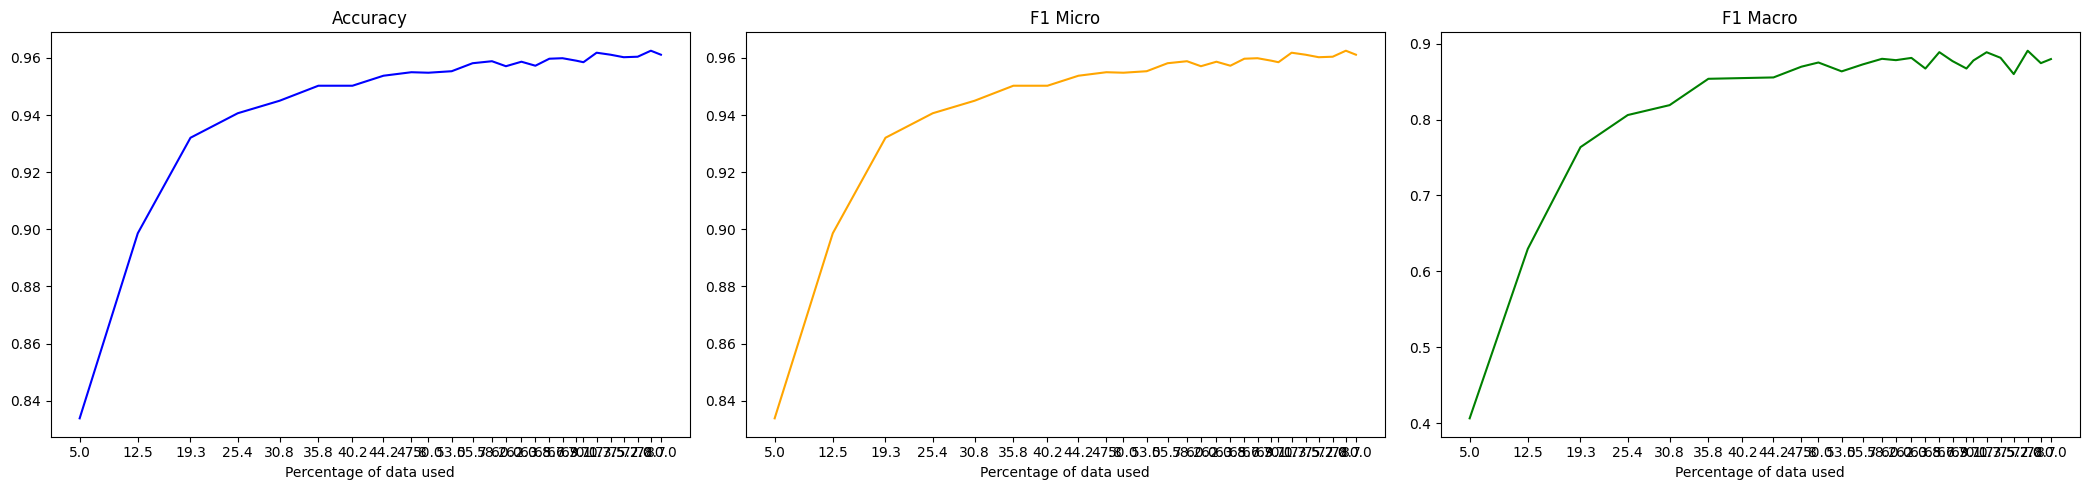

In [25]:
active_learning(seeds[0], 0)